## Import libraries


In [17]:
import argparse
import concurrent.futures
import json
import os
import warnings
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime, timedelta
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

warnings.filterwarnings("ignore")

WORK_DIR = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/"
os.chdir(WORK_DIR)
MAIN_DATA_DIR = "/beegfs/halder/DATA/"

In [18]:
CROP = "silage_maize"

## Read the dataset


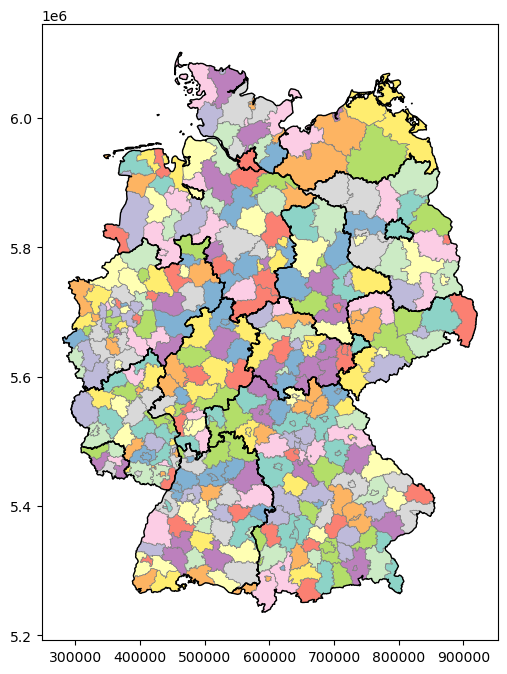

(16, 6) (400, 6)


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,geometry
0,DE11B,3,DE,Main-Tauber-Kreis,Main-Tauber-Kreis,"POLYGON ((546793.49 5514433.543, 546531.283 55..."
1,DE11C,3,DE,Heidenheim,Heidenheim,"MULTIPOLYGON (((585299.35 5401977.751, 585395...."
2,DE11D,3,DE,Ostalbkreis,Ostalbkreis,"MULTIPOLYGON (((591812.28 5434830.278, 591515...."
3,DE121,3,DE,"Baden-Baden, Stadtkreis","Baden-Baden, Stadtkreis","MULTIPOLYGON (((440009.175 5410196.803, 441490..."
4,DE122,3,DE,"Karlsruhe, Stadtkreis","Karlsruhe, Stadtkreis","POLYGON ((458238.847 5435551.545, 459823.952 5..."


In [19]:
# Read the NUTS1 and NUTS3 shapefile for DE
de_nuts1_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts1_gdf = de_nuts1_gdf[
    de_nuts1_gdf["LEVL_CODE"] == 1
]  # filter only NUT1 level code
de_nuts1_gdf.rename(
    columns={"NUTS_ID": "STATE_ID", "NUTS_NAME": "STATE_NAME"}, inplace=True
)

de_nuts3_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts3_gdf = de_nuts3_gdf[
    de_nuts3_gdf["LEVL_CODE"] == 3
]  # filter only NUT3 level code

de_nuts1_gdf.to_crs(crs="EPSG:25832", inplace=True)
de_nuts3_gdf.to_crs(crs="EPSG:25832", inplace=True)

fig, ax = plt.subplots(figsize=(8, 8))
de_nuts3_gdf.plot(
    ax=ax,
    column="NUTS_NAME",
    cmap="Set3",
    edgecolor="grey",
    linewidth=0.5,
    label="NUTS3",
)
de_nuts1_gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1, label="NUTS1")
plt.show()

print(de_nuts1_gdf.shape, de_nuts3_gdf.shape)
de_nuts3_gdf.head()

## Load the yield data


In [20]:
yield_df = pd.read_csv(
    os.path.join(WORK_DIR, "data", "processed", CROP, f"{CROP}_yield.csv")
)
print(yield_df.shape)
yield_df.head()

(14951, 6)


,NUTS_ID,year,crop,yield,baseline_yield,residual
0,DE111,1979,silage_maize,49.00,45.529,3.471
1,DE111,1980,silage_maize,44.09,45.886,-1.796
2,DE111,1981,silage_maize,45.51,46.244,-0.734
3,DE111,1982,silage_maize,47.63,46.599,1.031
4,DE111,1983,silage_maize,42.62,46.947,-4.327


## Check for climate data


In [21]:
climate_file_paths = glob(
    os.path.join(WORK_DIR, "data", "interim", "climate", CROP, "*.csv")
)
print("Number of climate files:", len(climate_file_paths))

climate_ids = [
    os.path.basename(path).replace(".csv", "").split("_") for path in climate_file_paths
]
climate_ids = pd.DataFrame(climate_ids, columns=["NUTS_ID", "year"])
climate_ids[["NUTS_ID", "year"]] = climate_ids[["NUTS_ID", "year"]]
climate_ids["year"] = climate_ids["year"].astype(int)
print("Number of climate NUTS IDs:", climate_ids["NUTS_ID"].nunique())
print(climate_ids.shape)
climate_ids.head()

Number of climate files: 10000
Number of climate NUTS IDs: 400
(10000, 2)


,NUTS_ID,year
0,DEB11,2002
1,DE804,2000
2,DE147,2006
3,DE932,2001
4,DE723,2007


## Check for remote sensing data


In [22]:
remote_sensing_file_paths = glob(
    os.path.join(
        WORK_DIR, "data", "interim", "remote_sensing", CROP, "combined", "*.csv"
    )
)
print("Number of remote sensing files:", len(remote_sensing_file_paths))

remote_sensing_ids = np.array(
    [os.path.basename(path).replace(".csv", "") for path in remote_sensing_file_paths]
)
start_year = 2001
end_year = 2024
remote_sensing_ids = [
    [i, y] for i in remote_sensing_ids for y in range(start_year, end_year + 1)
]
remote_sensing_ids = pd.DataFrame(remote_sensing_ids, columns=["NUTS_ID", "year"])
print(remote_sensing_ids.shape)
remote_sensing_ids.head()

Number of remote sensing files: 400
(9600, 2)


,NUTS_ID,year
0,DE40F,2001
1,DE40F,2002
2,DE40F,2003
3,DE40F,2004
4,DE40F,2005


## Check for static data


In [23]:
static_file_path = os.path.join(
    WORK_DIR, "data", "processed", CROP, f"{CROP}_static.csv"
)
static_ids = pd.read_csv(static_file_path).dropna()["NUTS_ID"].unique()
print("Number of unique static ids:", len(static_ids))

Number of unique static ids: 400


## Finalize the valid ids and train-test-split


(6823, 3)


,NUTS_ID,year,split
0,DE111,2001,train
1,DE111,2003,train
2,DE111,2007,train
3,DE112,2001,train
4,DE112,2002,train


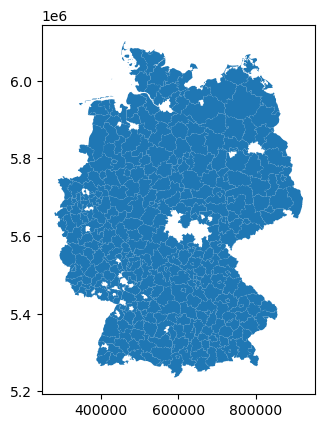

In [24]:
valid_ids = pd.merge(
    left=climate_ids, right=remote_sensing_ids, on=["NUTS_ID", "year"], how="inner"
)
valid_ids = pd.merge(
    left=valid_ids,
    right=yield_df[["NUTS_ID", "year"]],
    on=["NUTS_ID", "year"],
    how="inner",
)
valid_ids = valid_ids[valid_ids["NUTS_ID"].isin(static_ids)]

valid_ids.sort_values(by=["NUTS_ID", "year"], inplace=True)
valid_ids.reset_index(drop=True, inplace=True)
de_nuts3_gdf[de_nuts3_gdf["NUTS_ID"].isin(valid_ids["NUTS_ID"].unique())].plot()

# Assign train test split
valid_ids["split"] = valid_ids["year"].apply(
    lambda y: "train" if y <= 2018 else "val" if 2018 < y < 2022 else "test"
)

valid_ids.to_csv(
    os.path.join(WORK_DIR, "data", "processed", CROP, "train_test_val_split.csv"),
    index=False,
)
print(valid_ids.shape)
valid_ids.head()